In [1]:
#default_exp adaptive_unet

In [1]:
#hide
#export
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from fastai.vision.gan import *
from PIL import Image

import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import pdb

from HiDT.building_blocks import *
from HiDT.data_bunch import *

# Getting Images

In [2]:
def get_im():
    return (next(tit)[0].data[0]/2 + 0.5)[None,:]

In [3]:
data = DoubleImageList.from_folders(Path()/'horse2zebra', 'trainA', 'trainB').split_by_rand_pct(0.2).label_from_folder()

In [4]:
tit = iter(data.train)

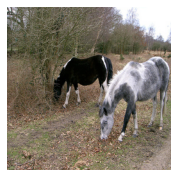

In [5]:
show_image(get_im()[0])

# Content Encoder
> "In our experiments, the content encoder has two downsampling and four residual blocks; after each downsampling, only five channels are used for
skip connections in order to limit the information flow
through them"

In [32]:
#export
class ContentEncoder(nn.Module):
    def __init__(self, ni=3):
        super().__init__()
        
        #downsampling
        
        down1 = Conv2dBlock(8, 16, ks=3, stride=2, norm="none", activation="relu")
        down2 = Conv2dBlock(32, 64, ks=3, stride=2, norm="none", activation="relu")
        
        res_sizes = [(3,8),(16,16),(16,32),(64,128)]

        #four residual blocks 
        res_blocks = [ResBlock(dim=d[0], dout=d[1]) for d in res_sizes]
        
        #final conv
        final = Conv2dBlock(128, 128, ks=3, stride=1)
        
        self.model = nn.Sequential(
            res_blocks[0],
            down1,
            res_blocks[1],
            res_blocks[2],
            down2,
            res_blocks[3],
            final
        )
        
        #hook activations for skip connections
        def hook_fn(mod, inp, out):
            self.hooks.append(out)
        
        for res in res_blocks:
            res.register_forward_hook(hook_fn)
        
        #Hook outputs, don't need to hook last layer
        self.hooks = []
        
    def forward(self, xb):
        self.hooks = []
        xb = self.model(xb)
        return xb, self.hooks
        

In [33]:
ce = ContentEncoder()

In [34]:
ce(get_im())[0].shape

torch.Size([1, 128, 64, 64])

In [35]:
content_feat, hooks = ce(get_im())

In [36]:
len(hooks)

4

# Style Encoder
> "The style encoder contains four downsampling blocks. The output of the style encoder is a
three-channel tensor, which is averaged-pooled into a three dimensional vector"

In [37]:
#export
class StyleEncoder(nn.Module):
    def __init__(self, ni=3, num_down=4, latent_size=3):
        super().__init__()
        
        self.down_layers = [
            Conv2dBlock(ni if i == 0 else 8*(2**(i-1)), 8*(2**i), ks=3, stride=2, norm="in", activation="relu") for i in range(num_down-1)
        ] + [Conv2dBlock(8*(2**(num_down-2)), latent_size, ks=3, stride=2, norm="in", activation="relu")]
        
        self.downsampling = nn.Sequential(*self.down_layers)
    
    def forward(self, xb):
        down = self.downsampling(xb)
        return down.mean(dim=-1).mean(dim=-1)

In [38]:
ds = StyleEncoder()

In [39]:
get_im().shape

torch.Size([1, 3, 256, 256])

In [40]:
ds(get_im()).shape

torch.Size([1, 3])

In [41]:
style_feat = ds(get_im())

# AdaIN Layer
> "AdaIN parameters are computed from the style vector via three-layer
fully-connected network"

In [42]:
#export
def get_adastats(features):
    bs, c = features.shape[:2]
    features = features.view(bs, c, -1)
    mean = features.mean(dim=2).view(bs,c,1,1)
    std = features.var(dim=2).sqrt().view(bs,c,1,1)
    
    return mean, std

In [43]:
#export
def AdaIN(content_feat, style_feat):
    #calculating channel and batch specific stats
    smean, sstd = get_adastats(style_feat.view(1,1,3))
    cmean, cstd = get_adastats(content_feat)
    
    csize = content_feat.size()
    
    norm_content = (content_feat - cmean.expand(csize)) / cstd.expand(csize)
    return norm_content * sstd.expand(csize) + smean.expand(csize)

In [44]:
after_ada = AdaIN(content_feat, style_feat)

In [45]:
after_ada.shape

torch.Size([1, 128, 64, 64])

In [ ]:
#export
class AdaSkipBlock(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.ada = AdaIN
        self.dense = Conv2dBlock(nin*2, nin, ks=3, stride=1)
    
    def forward(self, content, style, hook):
        ada = self.ada(hook, style)
        combined = torch.cat([content, ada], dim=1)
        return self.dense(combined)
        

In [ ]:
#export
class AdaResBlock(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        
        self.ada_block = AdaSkipBlock(nin, nin)
        self.res_block = ResBlock(nin, nout)
        
        self.skip = Conv2dBlock(nin, nout, 3, 1, activation="none") if nin != nout else None
    
    def forward(self, content, style, hook):
        ada = self.ada_block(content, style, hook)
        res = self.res_block(ada)
        
        if self.skip is not None:
            content = self.skip(content)
        
        return res + content
        

# Decoder
> "The decoder has five residual blocks
with AdaIN layers and two upsampling blocks"

In [108]:
#export
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Upsampling blocks
        self.up1 = UpBlock(64, 32)
        self.up2 = UpBlock(16, 8)
        
        #AdaIN Res Blocks
        ada_sizes = [(128, 128), (128, 64), (32, 16), (16,16), (8,3)]
        
        self.ada_skip_blocks = [
            AdaResBlock(d[0], d[1]) for d in ada_sizes
        ]
       
        
    def forward(self, xb, style, hooks):
        xb = self.ada_skip_blocks[0](xb, style, xb)
        xb = self.ada_skip_blocks[1](xb, style, hooks[3])
        xb = self.up1(xb)
        xb = self.ada_skip_blocks[2](xb, style, hooks[2])
        xb = self.ada_skip_blocks[3](xb, style, hooks[1])
        xb = self.up2(xb)
        xb = self.ada_skip_blocks[4](xb, style, hooks[0])
        return xb
    
    
        
        

In [109]:
dec = Decoder()

In [110]:
dec(content_feat, style_feat, hooks).shape

torch.Size([1, 3, 256, 256])